### Пункт 1

In [198]:
library(pdfCluster)
library(dbscan)
library(mclust)
library(cluster)
library(ggplot2)
library(MASS)
library(reshape2)

data(iris)

df <- iris[, 1:4 ]

In [199]:
df <- scale(df)
model_mclust <- Mclust(df, G=3)

clusters <- model_mclust$classification

iris_clustered <- cbind(iris, cluster = clusters)

table(iris_clustered$Species, iris_clustered$cluster)

errors <- sum(iris_clustered$Species != names(sort(table(iris_clustered$Species), decreasing = TRUE)[iris_clustered$cluster]))
cat("Количество ошибок:", errors)

            
              1  2  3
  setosa     50  0  0
  versicolor  0 45  5
  virginica   0  0 50

Количество ошибок: 5

In [200]:
model_pdfCluster <- pdfCluster(df, K=3)

clusters <- model_pdfCluster@clusters

iris_clustered <- cbind(iris, cluster = clusters)

table(iris_clustered$Species, iris_clustered$cluster)

# Количество ошибок
errors <- sum(iris_clustered$Species != names(sort(table(iris_clustered$Species), decreasing = TRUE)[iris_clustered$cluster]))
cat("Количество ошибок:", errors)

            
              1  2
  setosa     49  1
  versicolor  0 50
  virginica   0 50

Количество ошибок: 51

In [201]:
df <- iris[, 1:4]

# Функция для применения преобразований и кластеризации
cluster_with_transform <- function(transform_func, df){
  transformed_df <- apply(df, 2, transform_func)
  transformed_df <- scale(transformed_df) # Стандартизация после преобразования
  model_mclust <- Mclust(transformed_df, G = 3)
  clusters <- model_mclust$classification
  iris_clustered <- cbind(iris, cluster = clusters)
  errors <- sum(iris_clustered$Species != levels(iris$Species)[model_mclust$classification])
  return(list(errors = errors, table = table(iris_clustered$Species, iris_clustered$cluster)))
}

# Тестируем разные преобразования
results <- list()
results$original <- cluster_with_transform(identity, df)
results$log <- cluster_with_transform(log, df)
results$sqrt <- cluster_with_transform(sqrt, df)
results$minmax <- cluster_with_transform(function(x) (x - min(x)) / (max(x) - min(x)), df) # Min-max нормализация


for (name in names(results)) {
  cat(paste("\nРезультаты для", name, "преобразования:\n"))
  cat("Количество ошибок:", results[[name]]$errors, "\n")
  print(results[[name]]$table)
}


Результаты для original преобразования:
Количество ошибок: 5 
            
              1  2  3
  setosa     50  0  0
  versicolor  0 45  5
  virginica   0  0 50

Результаты для log преобразования:
Количество ошибок: 6 
            
              1  2  3
  setosa     50  0  0
  versicolor  0 44  6
  virginica   0  0 50

Результаты для sqrt преобразования:
Количество ошибок: 5 
            
              1  2  3
  setosa     50  0  0
  versicolor  0 45  5
  virginica   0  0 50

Результаты для minmax преобразования:
Количество ошибок: 5 
            
              1  2  3
  setosa     50  0  0
  versicolor  0 45  5
  virginica   0  0 50


Проведенные элементарные преобразования не привели к улучшению моделю, поэтому оставляем исходную MClust модель

### Пункт 2

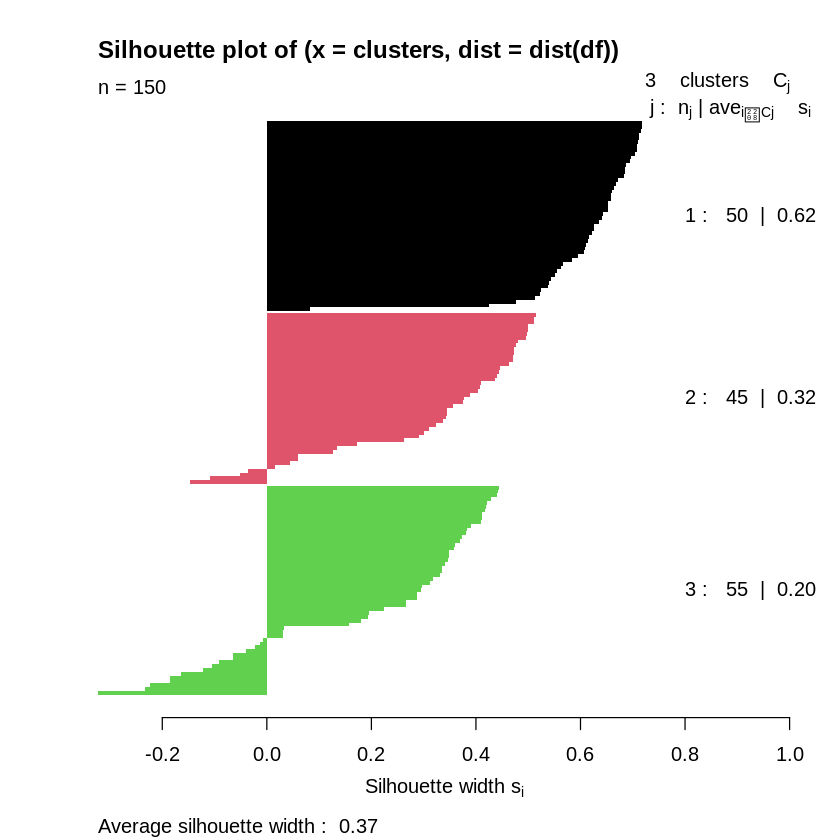

In [202]:
df <- scale(df)
model_mclust <- Mclust(df, G=3)
clusters <- model_mclust$classification
clusters <- model_mclust$classification
iris_clustered <- cbind(iris, cluster = clusters)

sil_values <- silhouette(clusters, dist(df))
plot(sil_values, col = 1:3, border = NA)

In [203]:
# Поиск наиболее типичного представителя
find_most_typical <- function(cluster_data, cluster_id) {
  cluster_subset <- cluster_data[iris_clustered$cluster == cluster_id, ]
  centroid <- colMeans(cluster_subset)
  distances <- apply(cluster_subset, 1, function(x) dist(rbind(x, centroid)))
  most_typical_index <- which.min(distances)

  row_index <- which(iris_clustered$cluster == cluster_id)[most_typical_index]

  return(list(index = row_index, data = cluster_subset[most_typical_index, ]))
}

# Gоиска наиболее нетипичного представителя
find_most_atypical <- function(cluster_data, cluster_id) {
  cluster_subset <- cluster_data[iris_clustered$cluster == cluster_id, ]
  centroid <- colMeans(cluster_subset)
  distances <- apply(cluster_subset, 1, function(x) dist(rbind(x, centroid)))
  most_atypical_index <- which.max(distances)

  row_index <- which(iris_clustered$cluster == cluster_id)[most_atypical_index]

  return(list(index = row_index, data = cluster_subset[most_atypical_index, ]))
}

for (i in 1:3)
{
  most_typical_result <- find_most_typical(df, i)
  most_atypical_result <- find_most_atypical(df, i)

  cat("Кластер", i, ":\n\n")
  cat("Наиболее типичный представитель:\n")
  cat("Индекс =", most_typical_result$index, "\n")
  print(most_typical_result$data)
  cat("\nНаиболее нетипичный представитель:\n")
  cat("Индекс =", most_atypical_result$index, "\n")
  print(most_atypical_result$data)
  cat("\n")
}

Кластер 1 :

Наиболее типичный представитель:
Индекс = 8 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
  -1.0184372    0.7861738   -1.2791040   -1.3110521 

Наиболее нетипичный представитель:
Индекс = 42 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
   -1.622254    -1.737536    -1.392399    -1.179859 

Кластер 2 :

Наиболее типичный представитель:
Индекс = 100 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
  -0.1730941   -0.5903951    0.1937350    0.1320673 

Наиболее нетипичный представитель:
Индекс = 61 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
  -1.0184372   -2.4258204   -0.1461509   -0.2615107 

Кластер 3 :

Наиболее типичный представитель:
Индекс = 148 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
   0.7930124   -0.1315388    0.8168591    1.0504160 

Наиболее нетипичный представитель:
Индекс = 132 
Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    2.483699     1.703886     1.496631     1.050416 



### Пункт 3

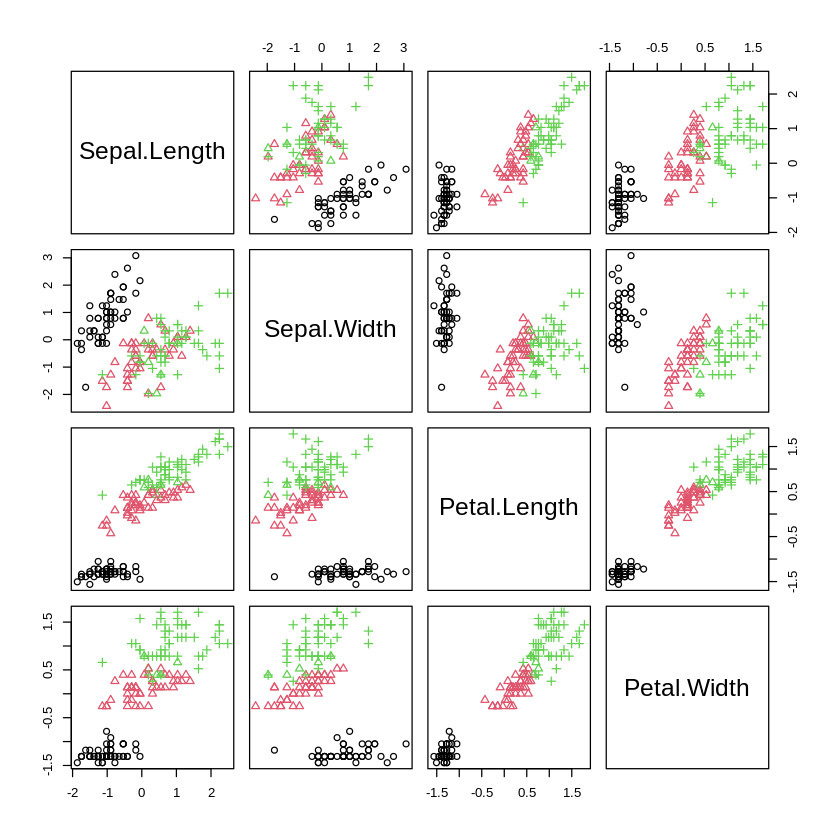

In [204]:
# попарные проекции переменных

pairs(df, col = clusters, pch = as.numeric(iris$Species))
legend("topleft", legend = levels(iris$Species), col = 1:3, pch = 1:3)

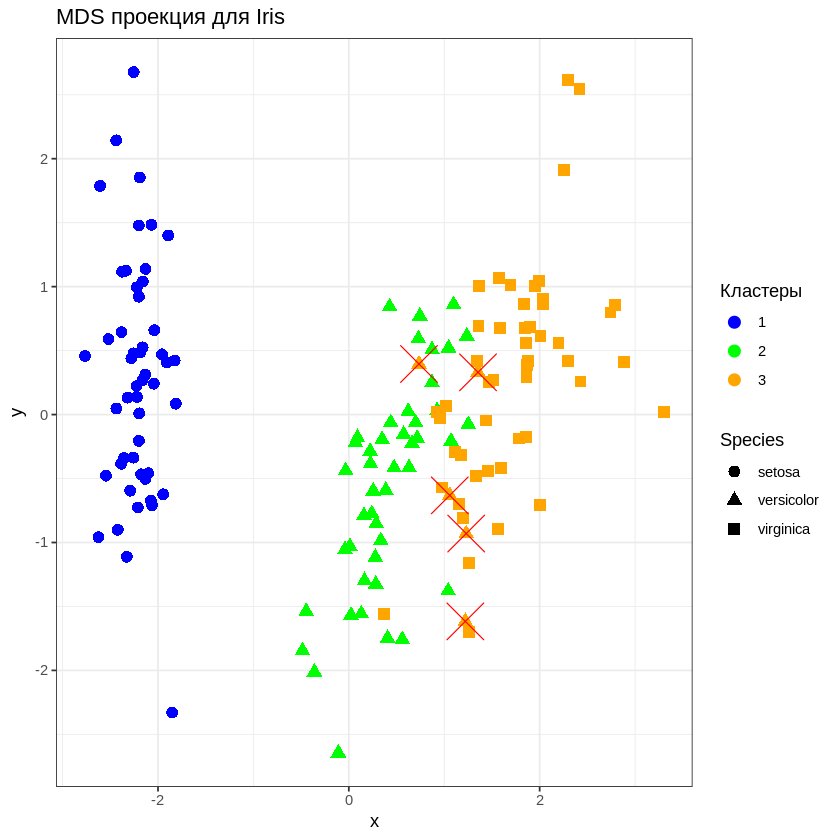

In [205]:
# MDS

distances <- dist(df)
mds <- cmdscale(distances, k = 2)
mds_df <- data.frame(x = mds[, 1], y = mds[, 2],
                     cluster = as.factor(clusters),
                     species = iris$Species,
                     error = ifelse(iris$Species != levels(iris$Species)[clusters], "Error", "Correct"))

my_colors <- setNames(c("blue", "green", "orange"), levels(mds_df$cluster))

ggplot(mds_df, aes(x = x, y = y, color = cluster, shape = species)) +
  geom_point(size = 3) +
  scale_color_manual(values = my_colors, name = "Кластеры") +
  labs(title = "MDS проекция для Iris", shape = "Species") +
  geom_point(data = subset(mds_df, error == "Error"), aes(x = x, y = y), color = "red", fill = "red", shape = 4, size = 10) + # ошибочные наблюдения
  theme_bw()

In [160]:
#install.packages('dbscan')
#install.packages("pdfCluster")
#install.packages('mclust')
#install.packages("cluster")
# install.packages('ggplot2')
# install.packages('MASS')
# install.packages('reshape2')